In [1]:
import cv2
import numpy as np
from skimage import feature
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import cv2 
import pyswarms as ps
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial import distance
sns.set_style("darkgrid")

plt.rcParams['figure.figsize'] = [9, 6]


In [3]:
# load dataset
with open('X-Train.npy', 'rb') as f:
    X_train = np.load(f)
    
with open('Y-Train.npy', 'rb') as f:
    Y_train = np.load(f)
    
with open('X-Test.npy', 'rb') as f:
    X_test = np.load(f)
    
with open('Y-Test.npy', 'rb') as f:
    Y_test = np.load(f)
    
with open('GA-LBP-Positions.npy', 'rb') as f:
    ga_pos = np.load(f)

with open('PSO-LBP-Positions.npy', 'rb') as f:
    pso_pos = np.load(f)

with open('ACO-LBP-Positions(1).npy', 'rb') as f:
    aco_pos = np.load(f)
   
Positions = [ga_pos,pso_pos,aco_pos,np.array([1]*256)]
Names = ["Genetic Algorithm","Particle Swarm Optimization","Ant Colony Optimization","Actual"]

In [4]:
# Define objective function for each particle
def ParticleFitness(m):
    
    k = list(map(str,list(m)))
    k = int("".join(k),2)

    classifier = KNeighborsClassifier(n_neighbors=k,metric="cosine")
    total_features = 6    
    classifier.fit(_X_train, Y_train)
    P = classifier.score(_X_test,Y_test)
    
    return 1-P

def Fitness(x, alpha=0.88,**k):
    
    file = open('PSO-KNN-Report.txt', 'a')
    n_particles = x.shape[0]
    result = []
    for i in range(n_particles):
        k = list(map(str,list(x[i])))
        k = int("".join(k),2)
        file.write(str(k)+", ")
        if k == 0:
            result.append(1)
        else:
            result.append(ParticleFitness(x[i]))
    file.write("\n")
    return np.array(result)

In [ ]:
options = {'c1': 1.4, 'c2': 1.4, 'w':0.8, 'k': 25, 'p':2}
dimensions = 6 
BestK = []
BestAcc = []
Charts = []

for index  in range(len(Positions)):
    print("Optimizing K value in K-NN with {0} features".format(Names[index]))
    _X_train = X_train[:,Positions[index]==1]
    _X_test = X_test[:,Positions[index]==1]
    
    optimizer = ps.discrete.BinaryPSO(n_particles=25, dimensions=dimensions, options=options)
    cost, pos = optimizer.optimize(Fitness,iters=75, verbose=2)
    optimizer.reset()
    k = list(map(str,list(pos)))
    k = int("".join(k),2)
    
    classifier = KNeighborsClassifier(n_neighbors=k,metric="cosine")
    classifier.fit(_X_train, Y_train)
    print("Best K found is: {0} and its score is {1}".format(k,classifier.score(_X_test,Y_test)))
    BestK.append(k)
    BestAcc.append(classifier.score(_X_test,Y_test))
    
    _chart = []
    for i in range(1,11):
        classifier = KNeighborsClassifier(n_neighbors=i,metric="cosine")
        classifier.fit(_X_train, Y_train)
        _chart.append(round(classifier.score(_X_test,Y_test)*100,2))
    Charts.append(_chart)
    print(_chart)
        

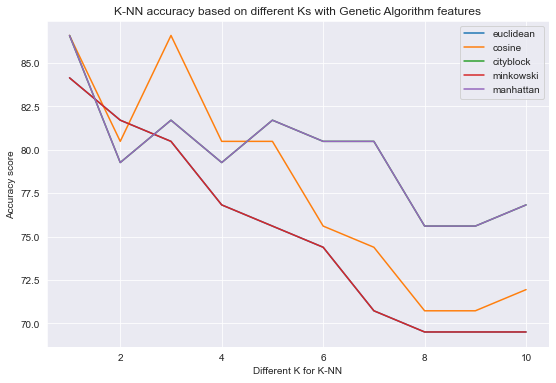

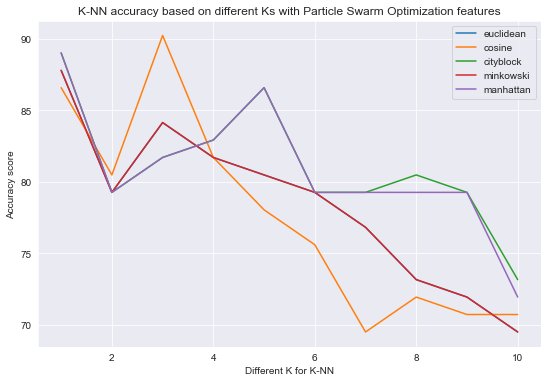

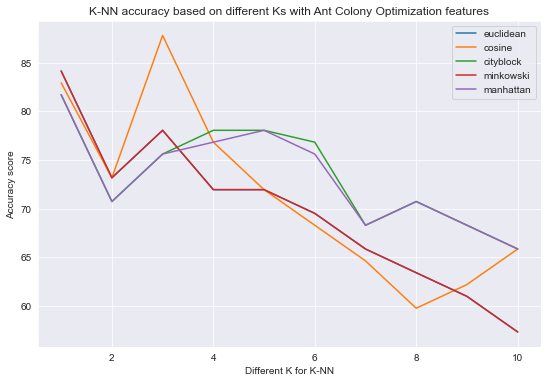

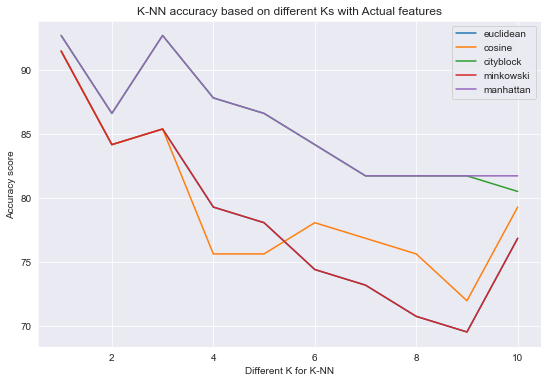

In [26]:
metric = ["euclidean","cosine","cityblock","minkowski","manhattan"]
for chart in range(len(Charts)):
    for met in metric: 
        _chart = []
        for k in range(1,11):
            if met == "cityblock": 
                classifier = KNeighborsClassifier(n_neighbors=k,metric=distance.cityblock)
            else:
                classifier = KNeighborsClassifier(n_neighbors=k,metric=met)
            _X_train = X_train[:,Positions[chart]==1]
            _X_test = X_test[:,Positions[chart]==1]
            classifier.fit(_X_train, Y_train)
            _chart.append(round(classifier.score(_X_test,Y_test)*100,2))
        plt.plot(list(range(1,11)),_chart,label=met)
    plt.legend()
    plt.title("K-NN accuracy based on different Ks with {0} features".format(Names[chart]))
    plt.xlabel("Different K for K-NN")
    plt.ylabel("Accuracy score")
    plt.show()
    
    

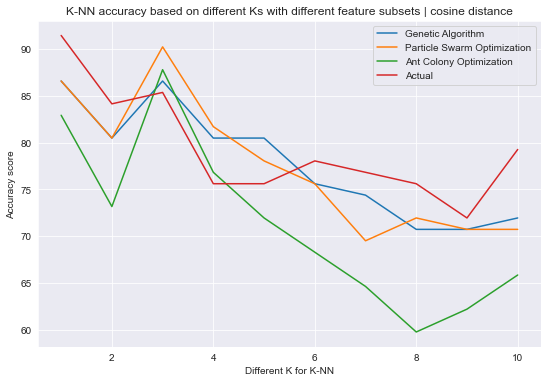

In [29]:
for chart in range(len(Charts)):
    plt.plot(list(range(1,11)),Charts[chart],label=Names[chart])
    plt.title("K-NN accuracy based on different Ks with different feature subsets | cosine distance".format(Names[chart]))
    plt.xlabel("Different K for K-NN")
    plt.ylabel("Accuracy score")
plt.legend()
plt.show()